# Pair Statistics
This file attempts to gather correlations and ratios between many combinations of pairs of stocks. This is the first part in a two-part process of obtaining and processing data.

After the correlated stocks are calculated (for a given offset), we choose the most correlated pair and gather sentiment analysis data (part two) on each of the chosen stocks.

To briefly recap where we are:
- from ***pair_stats***, we've determined that we wish to make predictions on COHR (Coherent Inc) based on 7 days of history of VAL
- from ***sentiment_analysis***, we've properly put together some sort of news scraper and analysis estimator. We will use this to collect our statistics on public sentiment of $COHR

In [1]:
!pip install nbimporter yfinance

In [2]:
# Local files
import nbimporter
from sentiment_analysis import RedditScraper, get_sentiment_data

In [3]:
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from datetime import datetime, timedelta, date
from os.path import exists
from tqdm.notebook import tqdm

In [4]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from pylab import *
from matplotlib.collections import LineCollection

### Define our Model

In [5]:
# Pretty basic LSTM thanks to https://cnvrg.io/pytorch-lstm/ with minor modifications
class LSTM_Stocks(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM_Stocks, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        
        # Dropout
        # Dense
        
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.relu = nn.ReLU()
        self.fc_2 = nn.Linear(128, num_classes) #fully connected last layer
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc_2(out) #Final Output
        return out

In [6]:
class Dataset(Dataset):
    def __init__(self,X,y,look_back=7):
#         assert(len(X) == len(y) + look_back)
        
        self.X = torch.tensor(X,dtype=torch.float)
        self.y = torch.tensor(y,dtype=torch.float)
        
#         self.look_back = look_back
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        # If we wanted, it could've been even easier to do it here than in create_dataset
#         return self.X[idx:idx+look_back], self.y[idx]

In the create_dataset method, this is where you can see data being pulled via the RedditScraper() in the sentiment_analysis file to give meaningful statistics on human input.

In [7]:
def create_dataset(dataset, datasetY, dates, look_back=7, ticker="COHR"):
    dataX, dataY = [], []
    
    sentiment = RedditScraper() 
    sdata = sentiment.gather_data(ticker)
    for i in range(len(dataset)-look_back):
        date = dates[i+look_back] # the day before the date we are predicting
        date = datetime.datetime.strptime(str(date).split('.')[0], '%Y-%m-%dT%H:%M:%S')
        sdata_stats = get_sentiment_data(sdata, for_date=date.date(), window=look_back)
        a = np.concatenate((dataset[i:(i+look_back), 0], sdata_stats))
        dataX.append(a)
        dataY.append(datasetY[i, 0])
    return np.array(dataX), np.array(dataY)

def create_sample(for_ticker="AAPL", from_ticker="TSLA", look_back=7, start="2000-01-01", end="2021-12-10"):
    start = datetime.datetime.strptime(start, '%Y-%m-%d')
    
    # Hard coded 2 extra days because of weekend (only for this run, need to fix later based on day of week)
    
    hist = yf.Ticker(for_ticker).history(start=start, end=end, actions=False)
    from_hist = yf.Ticker(from_ticker).history(start=(start - timedelta(look_back+2)), end=end, actions=False)

    dates = np.concatenate((np.array(from_hist.index), np.array(hist.index)[-look_back:]))
    
    # normalize data, create train set and test set using from_hist (we are predicting for_ticker using from_ticker)
    
    # Gather the 'close' data
    data, for_data = np.array(from_hist)[:, 3], np.array(hist)[:, 3]
    data, for_data = np.reshape(data, (-1, 1)), np.reshape(for_data, (-1, 1))

    ddata, for_ddata = np.empty_like(data), np.empty_like(for_data)
    ddata[1:-1], for_ddata[1:-1]  = (data[1:-1] - data[0:-2]) / data[0:-2], (for_data[1:-1] - for_data[0:-2]) / for_data[0:-2]
    ddata[0], for_ddata[0] = 0, 0
    ddata, for_ddata = ddata * 100, for_ddata * 100

    # 90/10 train/test split
    train_size = int(len(data) * 0.90)
    test_size = len(data) - train_size
    train, test = ddata[0:train_size, :], ddata[train_size-look_back:len(ddata), :]
    trainYs, testYs = for_ddata[0:train_size-look_back, :], for_ddata[train_size-look_back:len(for_ddata), :]

    # Scale the data
    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, trainYs, dates[:len(train)], look_back, ticker=for_ticker)
    testX, testY = create_dataset(test, testYs, dates[len(train):], look_back, ticker=for_ticker)
    
    return trainX, trainY, testX, testY, for_data, for_ddata, scaler

def create_dataloader(trainX, trainY, testX, testY, look_back=7, batch_size=10):
    # Turn into torch dataloaders
    train_dataset, test_dataset = Dataset(trainX,trainY, look_back=look_back), Dataset(testX, testY, look_back=look_back)
    tr_loader, te_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return tr_loader, te_loader

In [8]:
trainX, trainY, testX, testY, data, ddata, scaler = create_sample(
        for_ticker='COHR', from_ticker='VAL', look_back=7, start="2021-05-12")

In [9]:
tr_loader, te_loader = create_dataloader(trainX, trainY, testX, testY, look_back=7, batch_size=1)

In [10]:
# fix random seed for reproducibility
# np.random.seed(7)
def createModel(seqSize=1, feature_size=13, lookback=7):
    # num_classes, input_size, hidden_size, num_layers, seq_length
    return LSTM_Stocks(1, input_size=feature_size, hidden_size=1, num_layers=1, seq_length=lookback)

In [11]:
def trainModel(model, dataloader, epochs=10, lr=0.0001, verbose=False, num_epoch_output=1, file_name="LSTM_Stock.pt"):
    print('Train start...')

    batch_size = 10
    # reshape input to be [samples, time steps, features]
#     trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#     trainY2 = np.reshape(trainY, (trainY.shape[0]))
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Try to load best_mae
    best_mae = None
    if exists('SavedModels/bestmae.txt'):
        with open('SavedModels/bestmae.txt', 'r') as f:
            best_mae = float(f.read())
            print("Looking to beat best MAE of", best_mae)
    
    model.train()
    try:
        for epoch in tqdm(range(epochs), position=0, desc="Epochs"):

            running, batch_running, ct, batch_ct = 0, 0, 0, 0
            if (epoch+1) % num_epoch_output == 0:
                print('Epoch', epoch+1)

            # tqdm(, position=1, desc="Batches", total=len(dataloader)) removed for small dataset, high epoch
            for batch_idx, (stock1_prices, stock2_price) in enumerate(dataloader):     
                optimizer.zero_grad()

                # 3-dim
                y_pred = model(stock1_prices.unsqueeze(0))

                loss = criterion(y_pred.reshape(1), stock2_price) 
                running += loss.item()
                batch_running += loss.item()
                ct += 1
                batch_ct += 1
                loss.backward()
                optimizer.step()

                # Every debug_batch_interval iterations, print the data we've churned through (iterations * data per batch)
                if verbose and batch_idx % (len(dataloader) // debug_batch_interval) == 0:                
                    print('Epoch: {} [{}/{} ({:.0f}%)]\tBatch Loss: {:.2f}\tEpoch Loss: {:.2f}'.format(
                              epoch+1, batch_idx, len(dataloader) * batch_size,    # current sample num / total num
                              100. * batch_idx / len(dataloader), # this batch num's % of total dataset
                              batch_running // batch_ct, # the loss for this batch
                              running // ct) # running loss for the epoch
                         )
                    batch_running, batch_ct = 0, 0

            this_loss = running / ct
            if verbose:
                print("\nAverage Loss:", round(running / ct * 100) / 100.0,"\n")
            elif (epoch+1) % num_epoch_output == 0:
                print("Epoch", epoch+1, "Average Loss:", round(this_loss * 100) / 100.0)

            # Save our model
            if not best_mae:
                best_mae = this_loss
                checkpoint = {'state_dict': model.state_dict(),'optimizer': optimizer.state_dict()}
                torch.save(checkpoint, "SavedModels/" + file_name)
            if this_loss < best_mae:
                best_mae = this_loss
    #             print("New best model found! Saving with loss of", best_mae)

                # Write our best mae so we can keep track every time we retrain
                with open('SavedModels/bestmae.txt', 'w') as f:
                    f.write(str(best_mae))
                checkpoint = {'state_dict': model.state_dict(),'optimizer': optimizer.state_dict()}
                torch.save(checkpoint, "SavedModels/" + file_name)
    except:
        print("Error or user interrupted training... returning current model")
#     model.fit(trainX, trainY2, epochs=10, batch_size=10, verbose=2)
    print("Done")
    
    return model

In [12]:
model = createModel()
model = trainModel(model, tr_loader, epochs=10000, num_epoch_output=1000)

Train start...
Looking to beat best MAE of 0.7165374439653422


Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1000
Epoch 1000 Average Loss: 0.8
Epoch 2000
Epoch 2000 Average Loss: 0.64
Epoch 3000
Epoch 3000 Average Loss: 0.61
Epoch 4000
Epoch 4000 Average Loss: 0.6
Epoch 5000
Epoch 5000 Average Loss: 0.6
Epoch 6000
Epoch 6000 Average Loss: 0.6
Epoch 7000
Epoch 7000 Average Loss: 0.6
Epoch 8000
Epoch 8000 Average Loss: 0.6
Epoch 9000
Epoch 9000 Average Loss: 0.6
Epoch 10000
Epoch 10000 Average Loss: 0.6
Done


In [13]:
def testModel(model, dataloader):
    model.eval()
    criterion = torch.nn.MSELoss()
    preds = torch.tensor([])
    running, ct = 0, 0
    for batch_idx, (stock1_prices, stock2_price) in enumerate(dataloader):     

        # 3-dim
        y_pred = model(stock1_prices.unsqueeze(0))
        preds = torch.cat((preds, y_pred), dim=0)
        
        loss = criterion(y_pred.reshape(1), stock2_price) 
        running += loss.item()
        ct += 1

    this_loss = running / ct
    print("\nAverage Loss:", round(running / ct * 100) / 100.0,"\n")
            
    return preds.detach()

In [14]:
testModel(model, te_loader)


Average Loss: 0.48 



tensor([[ 0.1817],
        [-2.1118],
        [ 0.1817],
        [ 0.1817],
        [ 0.1817],
        [ 0.1817],
        [ 0.1817],
        [ 0.1817],
        [ 0.1817],
        [ 0.1817],
        [ 0.1817],
        [ 0.1817],
        [ 0.1479],
        [ 0.1817],
        [ 0.1817],
        [ 0.1817]])

In [15]:
def calcReturn(trainPredict, testPredict, data, ddata, look_back=7):
    # train and ddata are with offset look_back
    traPredict = np.reshape(trainPredict, len(trainPredict))
    tstPredict = np.reshape(testPredict, len(testPredict))
    iinvest = 100  # initial invest
    rtrain = np.ones(traPredict.shape) * iinvest
    rtest = np.ones(tstPredict.shape) * iinvest

    for i in range(trainPredict.shape[0]):
        p = traPredict[i]
        r = ddata[i+look_back, 0]/100
        if (i > 0):
            if (p > 0):  # long a position for a day
                rtrain[i] = rtrain[i-1] * (1+r)
            elif (p <= 0):  # short a position for a day
                rtrain[i] = rtrain[i-1] * (1-r)
    rettrdata = (data[traPredict.shape[0]+look_back] -
                 data[look_back])/data[look_back] - 1

    ###############################################################
    # for test --
    # at the very beginning your account has $100
    for i in range(testPredict.shape[0]):
        if i==0: # skip the first day
            continue
        # at day i, the scaled changes in close price of the days i-7 to i-1 of the highly correlated stock (ddata) are known
        #    run the classifier to predict ith day stock is increase (== 1) or decrease (== 0)
        p = tstPredict[i]
        
        r = ddata[i+len(trainPredict), 0]/100
        if (p > 0):  # the day i prediction is increase -->
            # 1. at day i-1 right before the end of the day, close all positions first
            #    close position means --if you bought stock the previous day, sell it at closing
            #                            price; if you sold stock the previous day, buy it back at
            #                            close price
            # 2. buy stock with all the money in your account
            #
            # as the result of the purchase, at the end of day i, the stock change is r. The value of
            # of the account becomes day i-1 value * (1 + r) at the end of day i
            rtest[i] = rtest[i-1] * (1+r)
        elif (p <= 0):  # the day i prediction is decrease -->
            # 1. at day i-1 right before the end of the day, close all your position first
            # 2. sell stock which you do not own (call short - you need buy iot back the next day)
            #
            # as the result of you sell, at the end of day i, the stock change is r. you need buy it back.
            # the gain is -r. The value of the account becomes day i-1 value * (1 - r) at the end
            # of day i
            rtest[i] = rtest[i-1] * (1-r)
            
    # rtest contains the value of your account based on your trading
    rettsdata = data[-1, 0] / \
        data[len(traPredict), 0]

    return rtrain, rtest, rettrdata, rettsdata

def showResult(ticker, trainPredict, testPredict, trainY, testY, data, ddata, scaler, look_back=7, show_daily_change=False, show_closing_price_preds=True):
    '''
        ticker - stock we are predicting
        trainPredict - our model's predictions from the training data
        testPredict - our model's predictions from the test data
        trainY - the actual closing prices from ticker (train portion of ddata)
        testY - the actual closing prices from ticker (test portion of ddata)
        data - closing prices of ticker
        ddata - change in closing price of ticker
    '''
    
    traPredict, tstPredict = trainPredict.squeeze(1), testPredict.squeeze(1)
    traY, tstY = trainY, testY
    
    traPredict,tstPredict = scaler.inverse_transform(traPredict), scaler.inverse_transform(tstPredict)
    traY, tstY = scaler.inverse_transform(traY), scaler.inverse_transform(tstY)
    
    trainScore = math.sqrt(mean_squared_error(traY, traPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(tstY, tstPredict))
    print('Test Score: %.2f RMSE' % (testScore))

    # shift train predictions by look_back for plotting
    traPredictPlot = np.zeros(data.shape[0])
    traPredictPlot[:] = np.nan
    traPredictPlot[:len(traPredict)] = traPredict

    # shift test predictions by look_back for plotting
    tstPredictPlot = np.zeros(data.shape[0])
    tstPredictPlot[:] = np.nan
    
    tstPredictPlot[len(traPredict):] = tstPredict

    if show_daily_change:
        # plot baseline and predictions
        plt.figure(num=None, figsize=(8, 6), dpi=150)
        plt.plot(ddata, 'b-')
        plt.plot(traPredictPlot, 'g--')
        plt.plot(tstPredictPlot, 'r-')
        plt.grid(which='minor')
        plt.title(ticker + ' Daily Price Change (Loss: {0})'.format(testScore))
        plt.legend(["Baseline", "LSTM Model (Train)", "LSTM Model (Test)"])
        plt.savefig("images/" + ticker + "-LSTM-rate.jpg")
        plt.show()

    # plot baseline and predictions
    tPlot = np.zeros((len(data)))
    tPlot[:] = np.nan
    tP = traPredict/100 + 1
    tP = traY/100 + 1
    tP = np.cumprod(tP)
    tP = data[look_back, 0] * tP
    
    tPlot[:len(traPredict)] = tP
    sPlot = np.zeros((len(data)))
    sPlot[:] = np.nan
    
    sP = tstPredict/100 + 1
    sP = np.cumprod(sP)
    sP = data[len(traPredict)+(look_back*2)+1] * sP
    
    sPlot[len(traPredict):] = sP

    if show_closing_price_preds:
        plt.figure(num=None, figsize=(8, 6), dpi=150)
        plt.plot(data, 'b-')
        plt.plot(tPlot, 'g--')
        plt.plot(sPlot, 'r-')
        plt.title(ticker + ' Closing Price Predictions (Loss: {0})'.format(testScore))
        plt.savefig("images/" + ticker + "-LSTM-price.jpeg")
        plt.legend(['Market Price', 'Train Predictions', 'Test Predictions'])
        plt.show()

    rtrain, rtest, rettrdata, rettsdata = calcReturn(
        trainPredict, testPredict, data, ddata, look_back=look_back)

    srPlot = np.zeros((len(rtest)))
    srPlot[:] = np.nan
    srP = data[len(traPredict), 0]/100 * rtest
    srPlot[:] = srP
    srdata = data[len(traPredict):]

#         print('srdata shape', srdata.shape)
#         print('srdata', srdata)

    # the red curve is the value of your account at each day - plotted in relative to the stock price
    # the blue line is market price. AKA the value of your account if you buy
    # at the beggining of the test period and never do anything again.

    plt.figure(num=None, figsize=(8, 6), dpi=150)
    plt.plot(srdata, 'b-', label='market price')
    plt.plot(srPlot, 'r-', label='trade return')
    plt.grid(b=True, which='both')
    plt.legend(loc='upper left')
    plt.title(ticker + '-LSTM' +
              ' trade return {0:.2f}% vs market return {1:.2f}%'.format(rtest[-1]-100, rettsdata))
    plt.savefig("images/" + ticker + "-LSTM-rate-price.jpeg")
    plt.show()

    copy, colors = [], []
    bt = colorConverter.to_rgba('r')
    gt = colorConverter.to_rgba('g')
    for i in range(srdata.shape[0]):
        r = ddata[i+len(trainPredict), 0]/100
        if traPredict[i] > 0:        # Predict price going up
            if r > 0:            # Price goes up... good trade
                colors.append(gt)
            else:                # Price goes down... bad trade
                colors.append(bt)
        else:                        # Predict price going down
            if r > 0:            # Goes up... bad trade
                colors.append(bt)
            else:                  # Goes down.. good trade
                colors.append(gt)
        copy.append((i, srdata[i][0]))

    segments = list(zip(copy[:-1], copy[1:]))
    ax = axes(frameon=True)
    ax.figure.set_size_inches(15, 10)
    LC = LineCollection(segments, colors=colors)
    ax.add_collection(LC)
    ax.set_title("Good/Bad Daily Predictions on Market Data")
    ax.set_xbound(lower=min(copy, key=lambda tup: tup[0])[0] - 5, upper=max(
        copy, key=lambda tup: tup[0])[0] + 5)
    ax.set_ybound(lower=min(copy, key=lambda tup: tup[1])[1] - 1, upper=max(
        copy, key=lambda tup: tup[1])[1] + 1)
    savefig("images/" + ticker + "-LSTM-good-bad-trades.jpeg")
    plt.show()

#     else:
#         trPlot = np.zeros((len(data)))
#         trPlot[:] = np.nan
#         trP = rtrain
#         trP = data[look_back, 0]/100 * trP
#         trPlot[look_back:len(traPredict)+look_back] = trP
#         srPlot = np.zeros((len(data)))
#         srPlot[:] = np.nan
#         srP = rtest
#         srP = data[len(traPredict)+(look_back*2)+1, 0]/100 * srP
#         srPlot[len(traPredict)+(look_back*2)+1:len(data)-1] = srP

#         plt.figure(num=None, figsize=(8, 6), dpi=150)
#         plt.plot(data, 'b-')
#         plt.plot(trPlot, 'g--')
#         plt.plot(srPlot, 'r-')
#         plt.title(ticker + '-LSTM' +
#                   ' trade return {0:.2f}% vs market return {1:.2f}%'.format(rtest[-1]-100, rettsdata*100))
#         plt.savefig("images/" + ticker + "-LSTM-rate-price.jpeg")
#         plt.show()

Train predictions

Average Loss: 0.6 

Test predictions

Average Loss: 0.48 

Train Score: 2.42 RMSE
Test Score: 2.17 RMSE


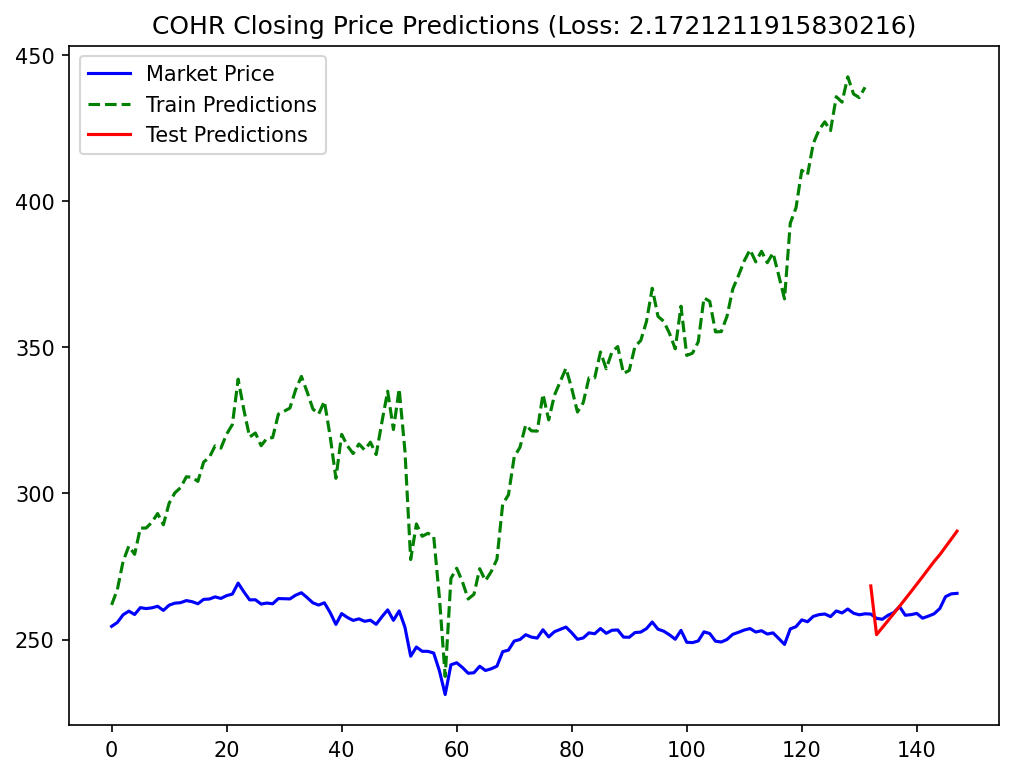

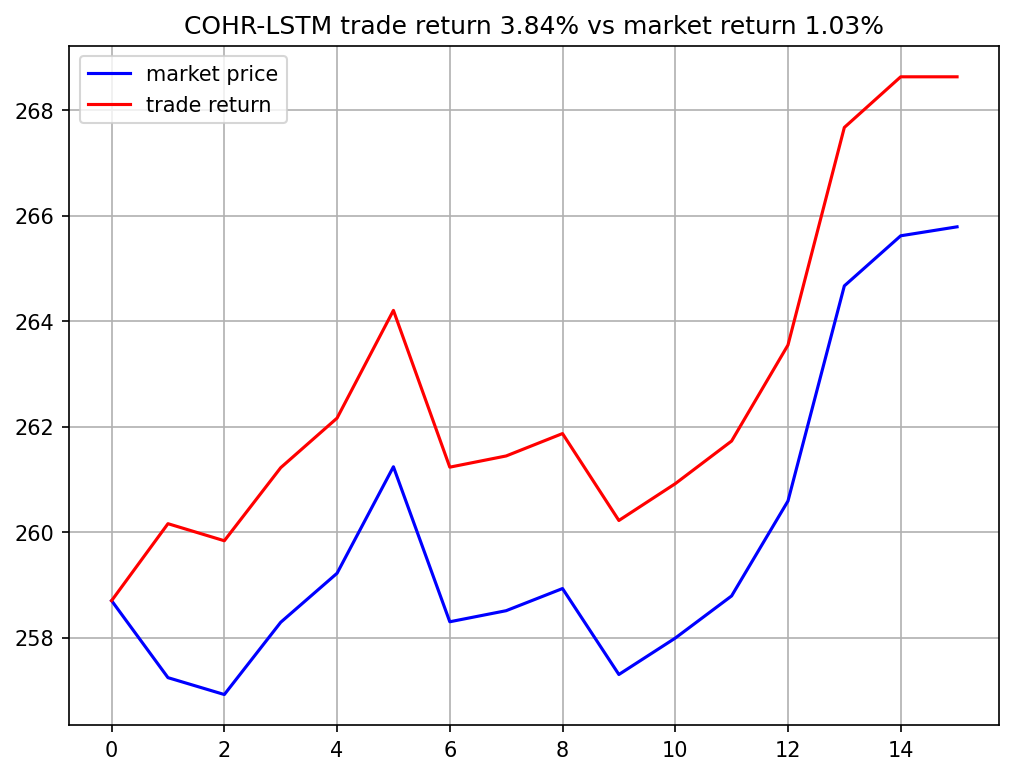

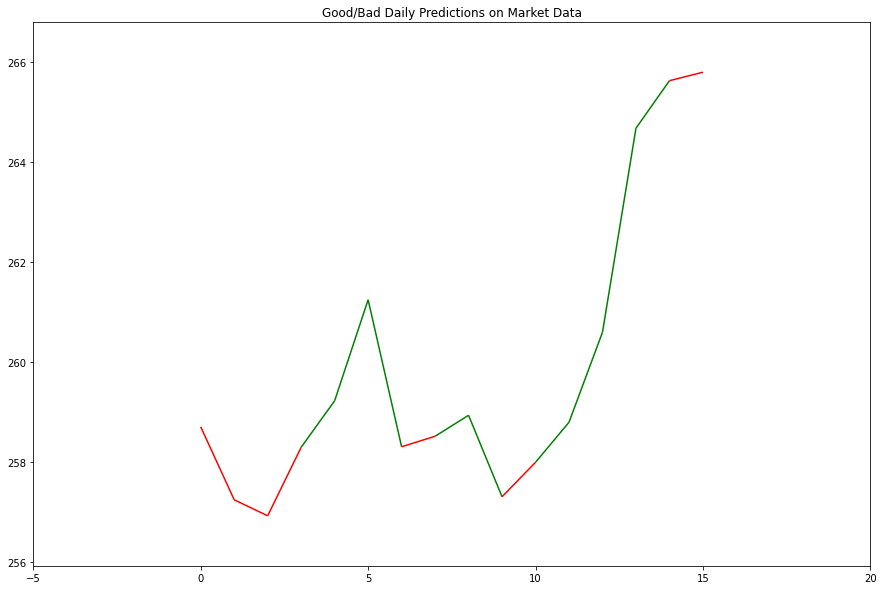

In [17]:
# start = "2021-05-01"
# look_back = 7

# # tickers = ["AAPL", "MSFT", "^GSPC"]
ticker = "COHR"

# for ticker in tickers:
#     print(ticker)
#     trainX, trainY, testX, testY, data, ddata, scaler = create_sample(
#         ticker=ticker, look_back=look_back, start=start)
#     model = createModel()
#     model = trainModel(model, trainX, trainY)
    # make predictions
print("Train predictions")
trainPredict = testModel(model, tr_loader)
print("Test predictions")
testPredict = testModel(model, te_loader)
showResult(ticker, trainPredict, testPredict,
               trainY, testY, data, ddata, scaler, look_back=7)